# AlexNet (Deep Convolutional Neural Network) の主要コンポーネントと実装

このノートブックでは、2012年のImageNet LSVRCで大きな成功を収めたAlexNetアーキテクチャの主要な構成要素と、そのPyTorchによる実装について学びます。
AlexNetは、より深いネットワーク、ReLU活性化関数、Dropout、Local Response Normalization (LRN)、複数GPUによる学習といった新しいアイデアを導入し、その後の深層学習研究に大きな影響を与えました。

**参考論文:**
*   Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). ImageNet classification with deep convolutional neural networks. In *Advances in neural information processing systems* (Vol. 25).

**このノートブックで学ぶこと:**
1.  AlexNetのアーキテクチャの概要
2.  主要な新しいコンポーネントの理解とNumPyによる概念実装:
    *   ReLU活性化関数 (再確認)
    *   Local Response Normalization (LRN)
    *   Dropout
    *   Overlapping Pooling
3.  PyTorchを使ったAlexNetモデルの実装
4.  CIFAR-10データセットでの学習と評価（簡易版）

**前提知識:**
*   LeNet-5のノートブックで学んだCNNの基礎（畳み込み、プーリング、全結合層）
*   PyTorchの基本的な使い方（モデル定義、データローダー、学習ループ）

 ## 1. 必要なライブラリのインポート

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time

print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch Version: 2.6.0+cu124
Torchvision Version: 0.21.0+cu124
Using device: cuda


## 2. AlexNetの主要な新しいコンポーネントとNumPyによる概念実装

AlexNetは、LeNet-5をベースにしながらも、いくつかの重要な新しい要素を導入しました。

### 2.1 ReLU活性化関数 (Rectified Linear Unit) - 再確認

*   **概念:**
    $\text{ReLU}(x) = \max(0, x)$
    AlexNetでは、従来のSigmoidやTanhといった飽和する活性化関数ではなく、非飽和のReLUが全面的に採用されました。これにより、勾配消失問題が緩和され、深いネットワークの学習が大幅に高速化されました。
*   **微分:** $\text{ReLU}'(x) = 1 \text{ if } x > 0 \text{ else } 0$

(NumPyによる実装はMLPまたはLeNet-5のノートブックで既出のため、ここでは再掲を省略し、PyTorchでは `nn.ReLU()` を使用します)

### 2.2 Local Response Normalization (LRN)

*   **概念:**
    LRNは、生物の神経系で見られる側方抑制（lateral inhibition）に着想を得た正規化手法です。同じ空間位置にあるが異なるカーネル（チャネル）によって計算されたニューロンの応答間で競合を生じさせ、大きな応答をさらに強調し、小さな応答を抑制する効果があります。
    論文では、ReLUの後に適用され、汎化性能の向上に寄与したとされています。
    
    $i$番目のカーネルによる位置$(x,y)$での活性化値 $a^i_{x,y}$ に対する正規化後の値 $b^i_{x,y}$ は以下のように計算されます。
    
    $b^i_{x,y} = \frac{a^i_{x,y}}{\left(k + \frac{\alpha}{n} \sum_{j=\max(0, i-n/2)}^{\min(N-1, i+n/2)} (a^j_{x,y})^2\right)^\beta}$
    
    ここで、
    *   $N$: 同じ空間位置にあるカーネル（チャネル）の総数。
    *   $n$: 正規化ウィンドウのサイズ（隣接するいくつのチャネルを見るか）。
    *   $k, \alpha, \beta$: ハイパーパラメータ。論文では $k=2, n=5, \alpha=10^{-4}, \beta=0.75$。
    
    **注意:** LRNは現代のCNNアーキテクチャでは、Batch Normalizationなどのより効果的な正規化手法に取って代わられることが多いです。しかし、AlexNetの重要な構成要素の一つとして理解しておく価値があります。

In [23]:
def local_response_normalization(feature_maps, n=5, k=2, alpha=1e-4, beta=0.75):
    '''
    Local Response Normalization (LRN) の実装
    parameters:
        feature_maps: 入力の特徴マップ (バッチサイズ， チャンネル数，高さ，幅)
        n: 正規ウィンドウのサイズ
        k, alpha, beta: LRNのパラメータ
    returns:
        正規化された特徴マップ
    '''
    if feature_maps.ndim != 4:
        raise ValueError("Input feature_maps must be a 4D tensor (batch_size, channels, height, width)")

    batch_size, num_channels, height, width = feature_maps.shape
    normalized_maps = np.zeros_like(feature_maps)

    # 各チャネル，各ピクセル位置で計算
    for b_idx in range(batch_size):
        for y_idx in range(height):
            for x_idx in range(width):
                for c_idx in range(num_channels):
                    # 正規化ウィンドウの範囲を決定
                    sum_start = max(0, c_idx - n // 2)
                    sum_end = min(num_channels - 1, c_idx + n // 2)

                    # 隣接チャネルの応答の二乗和
                    sum_sq_response = 0.0
                    for j_idx in range(sum_start, sum_end + 1):
                        sum_sq_response += feature_maps[b_idx, j_idx, y_idx, x_idx] ** 2

                    denominator = (k + (alpha / n) * sum_sq_response) ** beta
                    normalized_maps[b_idx, c_idx, y_idx, x_idx] = feature_maps[b_idx, c_idx, y_idx, x_idx] / denominator
    return normalized_maps

In [24]:
# テスト
print("--- LRNテスト ---")
# ダミー入力 (バッチサイズ1, 3チャネル, 2x2画像)
dummy_lrn_input = np.random.rand(1, 3, 2, 2).astype(np.float32) * 5
display("LRN入力:\n", dummy_lrn_input)

lrn_output_numpy = local_response_normalization(dummy_lrn_input)
display("\nLRN出力 (NumPy):\n", lrn_output_numpy)

# PyTorchにも nn.LocalResponseNorm があるので比較可能
lrn_torch_layer = nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2)
lrn_output_torch = lrn_torch_layer(torch.from_numpy(dummy_lrn_input))
display("\nLRN出力 (PyTorch):\n", lrn_output_torch.detach().numpy())

--- LRNテスト ---


'LRN入力:\n'

array([[[[4.6411304, 0.3323043],
         [4.830922 , 2.6976955]],

        [[4.4704013, 1.8251495],
         [1.6478771, 3.2665422]],

        [[2.4565368, 0.9948551],
         [0.2036429, 1.8551968]]]], dtype=float32)

'\nLRN出力 (NumPy):\n'

array([[[[2.7586486 , 0.19758275],
         [2.8719213 , 1.6038021 ]],

        [[2.6571686 , 1.0852044 ],
         [0.97964185, 1.9419861 ]],

        [[1.4601446 , 0.5915247 ],
         [0.1210631 , 1.1029297 ]]]], dtype=float32)

'\nLRN出力 (PyTorch):\n'

array([[[[2.7586486 , 0.19758275],
         [2.8719213 , 1.6038021 ]],

        [[2.6571686 , 1.0852044 ],
         [0.97964185, 1.9419861 ]],

        [[1.4601446 , 0.5915247 ],
         [0.1210631 , 1.1029297 ]]]], dtype=float32)

### 2.3 Dropout

*   **概念:**
    Dropoutは、訓練時にニューラルネットワークの過学習を抑制するための非常に効果的な正則化手法です。
    *   **訓練時:** 各訓練バッチにおいて、隠れ層の各ニューロンを一定の確率 $p$ (通常0.5など) でランダムに「ドロップアウト」（無効化）します。つまり、そのニューロンの出力は0になり、順伝播・逆伝播の計算にも関与しません。これにより、毎回異なる部分的なネットワークが学習されることになり、ニューロン間の複雑な共適応（co-adaptation）が抑制され、より頑健な特徴が学習されることが期待されます。
    *   **推論（テスト）時:** 全てのニューロンを使用しますが、訓練時にニューロンをドロップアウトしたことによる出力スケールの変化を補正するために、各ニューロンの出力を確率 $(1-p)$ でスケーリングします（Inverted Dropoutと呼ばれる手法では、訓練時に $(1-p)$ で割っておくことで、テスト時は何もしなくてよくなります）。または、多数のドロップアウトされたネットワークの予測を平均化する操作を近似します。

*   **NumPyによる概念実装 (順伝播時の適用):**
    （逆伝播もドロップアウトされたニューロンの勾配は0になります）

In [25]:
def dropout_forward(x, p_dropout, is_training=True):
    '''
    Dropoutの順伝播（Inverted Dropoutではない）
    parameters:
        x: 入力テンソル
        p_dropout: ドロップアウト率
        is_training: 訓練時か推論時か
    returns:
        tupple: (output, mask) または (output, None)
                output: ドロップアウト後の出力テンソル
                mask: 訓練時に使用したドロップアウトマスク
    '''
    if not (0 <= p_dropout < 1):
        raise ValueError("p_dropout must be in the range [0, 1)")

    if is_training:
        # 訓練時：（1-p_dropout）の確率でニューロンを保持
        # マスクを生成（ベルヌーイ分布からサンプリング）
        # Xと同じ形状で，各要素が （1-p_dropout）である確率で1, それ以外は0
        mask = (np.random.rand(*x.shape) > p_dropout).astype(np.float32)
        output = x * mask
        return output, mask

    else:
        # 推論時：ドロップアウトは適用しないが、スケーリングを行う
        output = x * (1 - p_dropout)
        return output, None

In [26]:
# テスト
print("\n--- Dropoutテスト ---")
dummy_dropout_input = np.array([[1,2,3,4,5], [6,7,8,9,10]], dtype=np.float32)
p_drop = 0.5
print("Dropout入力:\n", dummy_dropout_input)

# 訓練時
output_train, mask_train = dropout_forward(dummy_dropout_input, p_drop, is_training=True)
print(f"\nDropout出力 (訓練時, p={p_drop}):\n", output_train)
print("使用されたマスク:\n", mask_train)

# 推論時
output_test, _ = dropout_forward(dummy_dropout_input, p_drop, is_training=False)
print(f"\nDropout出力 (推論時, p={p_drop}, スケーリング係数={1.0-p_drop}):\n", output_test)

# Inverted Dropout の場合:
# 訓練時: output = (X * mask) / (1.0 - p_dropout)
# 推論時: output = X (何もしない)
# PyTorchの nn.Dropout はデフォルトで Inverted Dropout のように振る舞います (推論時は何もしない)。


--- Dropoutテスト ---
Dropout入力:
 [[ 1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10.]]

Dropout出力 (訓練時, p=0.5):
 [[1. 0. 3. 0. 5.]
 [6. 7. 0. 9. 0.]]
使用されたマスク:
 [[1. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0.]]

Dropout出力 (推論時, p=0.5, スケーリング係数=0.5):
 [[0.5 1.  1.5 2.  2.5]
 [3.  3.5 4.  4.5 5. ]]


### 2.4 Overlapping Pooling

*   **概念:**
    従来のプーリング（例: LeNet-5のS2, S4）では、プーリングウィンドウが重ならないようにストライドをウィンドウサイズと同じに設定することが一般的でした（non-overlapping pooling）。
    AlexNetでは、ストライドをウィンドウサイズよりも小さく設定する**Overlapping Pooling**が使用されました（例: ウィンドウサイズ3x3、ストライド2）。
    これにより、より多くの情報が次の層に伝播し、過学習をわずかに抑制し、性能向上に繋がったと報告されています。

*   **実装:**
    以前LeNet-5のノートブックで実装した`max_pool2d`関数は、`pool_size`と`stride`を個別に指定できるため、Overlapping Poolingも表現できます。
    (NumPy版 `max_pool2d` の実装はLeNet-5ノートブック参照、またはPyTorchでは `nn.MaxPool2d(kernel_size, stride)` で簡単に実現できます)

## 3. AlexNet アーキテクチャの概要

AlexNetのアーキテクチャは、LeNet-5よりも深く、広くなっています。論文 (Figure 2) に基づく主な構成は以下の通りです。
（論文では2つのGPUで並列に処理する構造が描かれていますが、ここでは単一GPUで処理する場合の論理的な構造を示します）

1.  **入力:** 224x224x3 ピクセルのRGB画像 (論文では入力パッチサイズ227x227と記載されることもあるが、最初の畳み込みの計算から逆算すると224x224が整合するケースや、227x227でパディング調整するケースなど文献により差異あり。ここでは一般的な224x224を想定)。

2.  **第1畳み込み層 (Conv1):**
    *   カーネル数: 96
    *   カーネルサイズ: 11x11
    *   ストライド: 4
    *   パディング: (計算上、出力が55x55になるように調整。例えば padding=2)
    *   出力: 96枚の 55x55 特徴マップ。
    *   活性化: ReLU
    *   **LRN層がこの後に続く**
    *   **Overlapping Max Pooling層がこの後に続く** (3x3ウィンドウ、ストライド2) → 出力 27x27

3.  **第2畳み込み層 (Conv2):**
    *   カーネル数: 256
    *   カーネルサイズ: 5x5
    *   ストライド: 1
    *   パディング: 2 ('same'に近い)
    *   入力: 第1プーリング層の出力 (96チャネル、27x27)
    *   出力: 256枚の 27x27 特徴マップ。
    *   活性化: ReLU
    *   **LRN層がこの後に続く**
    *   **Overlapping Max Pooling層がこの後に続く** (3x3ウィンドウ、ストライド2) → 出力 13x13

4.  **第3畳み込み層 (Conv3):**
    *   カーネル数: 384
    *   カーネルサイズ: 3x3
    *   ストライド: 1
    *   パディング: 1 ('same')
    *   入力: 第2プーリング層の出力 (256チャネル、13x13)
    *   出力: 384枚の 13x13 特徴マップ。
    *   活性化: ReLU

5.  **第4畳み込み層 (Conv4):**
    *   カーネル数: 384
    *   カーネルサイズ: 3x3
    *   ストライド: 1
    *   パディング: 1 ('same')
    *   入力: 第3畳み込み層の出力 (384チャネル、13x13)
    *   出力: 384枚の 13x13 特徴マップ。
    *   活性化: ReLU

6.  **第5畳み込み層 (Conv5):**
    *   カーネル数: 256
    *   カーネルサイズ: 3x3
    *   ストライド: 1
    *   パディング: 1 ('same')
    *   入力: 第4畳み込み層の出力 (384チャネル、13x13)
    *   出力: 256枚の 13x13 特徴マップ。
    *   活性化: ReLU
    *   **Overlapping Max Pooling層がこの後に続く** (3x3ウィンドウ、ストライド2) → 出力 6x6

7.  **フラット化:** 第5プーリング層の出力 (256チャネル、6x6) をフラット化 → $256 \times 6 \times 6 = 9216$ユニット。

8.  **第1全結合層 (FC1 / FC6):**
    *   入力ユニット数: 9216
    *   出力ユニット数: 4096
    *   活性化: ReLU
    *   **Dropout適用** ($p=0.5$)

9.  **第2全結合層 (FC2 / FC7):**
    *   入力ユニット数: 4096
    *   出力ユニット数: 4096
    *   活性化: ReLU
    *   **Dropout適用** ($p=0.5$)

10. **出力層 (FC3 / FC8):**
    *   入力ユニット数: 4096
    *   出力ユニット数: 1000 (ImageNetのクラス数)
    *   活性化: Softmax (分類のため)

**複数GPUでの学習:**
論文では、2つのGPUにモデルを分割して学習を行っています。例えば、畳み込み層のカーネルを半分ずつ各GPUに割り当て、特定の層でのみGPU間で通信を行います。これにより、より大きなモデルを学習可能にしました。

## 4. PyTorchによるAlexNetの実装とCIFAR-10での学習・評価 (簡易版)

ImageNetデータセットは非常に大きく、学習に多くの計算資源と時間が必要です。
ここでは、AlexNetのアーキテクチャを参考にしつつ、より小さなCIFAR-10データセット（32x32のカラー画像、10クラス）用に調整した簡易版AlexNetをPyTorchで実装し、学習と評価を行います。

**CIFAR-10用への主な変更点:**
*   入力サイズ: 32x32x3
*   出力クラス数: 10
*   層のチャネル数や全結合層のユニット数は、元のAlexNetよりも削減して計算負荷を軽減します。
*   LRNはPyTorchの `nn.LocalResponseNorm` を使用します。
*   Dropoutは `nn.Dropout` を使用します。

In [27]:
# CIFAR-10 データセットの準備
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # RGB各チャネルの平均と標準偏差を0.5に
])

train_dataset_cifar = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                   download=True, transform=transform_cifar)
test_dataset_cifar = torchvision.datasets.CIFAR10(root='./data', train=False,
                                                  download=True, transform=transform_cifar)

# CIFAR-10は画像サイズが小さいのでバッチサイズを少し大きめに
batch_size_cifar = 128
train_loader_cifar = DataLoader(train_dataset_cifar, batch_size=batch_size_cifar, shuffle=True, num_workers=2)
test_loader_cifar = DataLoader(test_dataset_cifar, batch_size=batch_size_cifar, shuffle=False, num_workers=2)

classes_cifar = ('plane', 'car', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"CIFAR-10 訓練データセットのサンプル数: {len(train_dataset_cifar)}")
print(f"CIFAR-10 テストデータセットのサンプル数: {len(test_dataset_cifar)}")
dataiter_cifar = iter(train_loader_cifar)
images_cifar, labels_cifar = next(dataiter_cifar)
print("\nCIFAR-10 1バッチの画像の形状:", images_cifar.shape) # (batch_size, 3, 32, 32)

CIFAR-10 訓練データセットのサンプル数: 50000
CIFAR-10 テストデータセットのサンプル数: 10000

CIFAR-10 1バッチの画像の形状: torch.Size([128, 3, 32, 32])


In [28]:
class AlexNetCIFAR(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetCIFAR, self).__init__()
        # CIFAR-10 (32x32x3) 用に調整
        self.features = nn.Sequential(
            # Conv1: (32-5+2*0)/1 + 1 = 28 ? 論文では (224 -> 55 stride 4)
            # CIFAR-10用に調整: kernel=5, stride=1, padding=2 -> (32-5+2*2)/1+1 = 32.
            # または kernel=3, stride=1, padding=1 -> 32
            # ここでは一般的な構成に少し近づける
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), # (32x32x3) -> (32x32x64)
            nn.ReLU(inplace=True),
            # LRN (論文ではk=2, n=5, alpha=1e-4, beta=0.75)
            # nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2), # PyTorchのLRNはsizeがn
            nn.MaxPool2d(kernel_size=2, stride=2), # (32x32x64) -> (16x16x64)

            nn.Conv2d(64, 192, kernel_size=3, padding=1), # (16x16x64) -> (16x16x192)
            nn.ReLU(inplace=True),
            # nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=2, stride=2), # (16x16x192) -> (8x8x192)

            nn.Conv2d(192, 384, kernel_size=3, padding=1), # (8x8x192) -> (8x8x384)
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1), # (8x8x384) -> (8x8x256)
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1), # (8x8x256) -> (8x8x256)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # (8x8x256) -> (4x4x256)
        )
        # プーリング層の後、全結合層の前にAdaptiveAvgPool2dを入れると入力サイズに柔軟性が出る
        # self.avgpool = nn.AdaptiveAvgPool2d((6, 6)) # AlexNet原論文のFC入力前のサイズに合わせる場合

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 4 * 4, 1024), # 256チャネル、4x4の特徴マップ
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1) # Flatten
        x = self.classifier(x)
        return x

In [29]:
model_alexnet_cifar = AlexNetCIFAR(num_classes=10).to(device)
print("\nAlexNet-style Model for CIFAR-10:\n", model_alexnet_cifar)

# ダミー入力でフォワードパスのテスト
dummy_input_cifar = torch.randn(batch_size_cifar, 3, 32, 32).to(device)
output_dummy_cifar = model_alexnet_cifar(dummy_input_cifar)
print("\nCIFAR Dummy Input Shape:", dummy_input_cifar.shape)
print("CIFAR Dummy Output Shape (Logits):", output_dummy_cifar.shape)


AlexNet-style Model for CIFAR-10:
 AlexNetCIFAR(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=1024, bias=True)
    (2): ReLU

In [30]:
# 損失関数とOptimizer
criterion_alexnet = nn.CrossEntropyLoss()
optimizer_alexnet = optim.Adam(model_alexnet_cifar.parameters(), lr=0.001)
# optimizer_alexnet = optim.SGD(model_alexnet_cifar.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4) # SGD+Momentum+WeightDecayも一般的

In [31]:
num_epochs_alexnet = 20 # エポック数
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print(f"\nAlexNet-style 学習開始 (CIFAR-10データ、{num_epochs_alexnet} epochs)...")

for epoch in range(num_epochs_alexnet):
    model_alexnet_cifar.train() # モデルを訓練モードに設定
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader_cifar):
        images = images.to(device)
        labels = labels.to(device)

        # 順伝播
        outputs = model_alexnet_cifar(images)
        loss = criterion_alexnet(outputs, labels)

        # 逆伝播と最適化
        optimizer_alexnet.zero_grad()
        loss.backward()
        optimizer_alexnet.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        if (i+1) % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs_alexnet}], Step [{i+1}/{len(train_loader_cifar)}], Loss: {loss.item():.4f}")

    epoch_loss_train = running_loss / len(train_loader_cifar)
    epoch_acc_train = 100 * correct_train / total_train
    train_losses.append(epoch_loss_train)
    train_accuracies.append(epoch_acc_train)

    # -- 各エポック終了時にテストデータで評価 --
    model_alexnet_cifar.eval() # モデルを評価モードに設定
    correct_test = 0
    total_test = 0
    running_test_loss = 0.0

    with torch.no_grad(): # 勾配計算を無効化
        for images_test, labels_test in test_loader_cifar:
            images_test = images_test.to(device)
            labels_test = labels_test.to(device)

            outputs_test = model_alexnet_cifar(images_test)
            loss_test = criterion_alexnet(outputs_test, labels_test)
            running_test_loss += loss_test.item()

            _, predicted_test = torch.max(outputs_test.data, 1)
            total_test += labels_test.size(0)
            correct_test += (predicted_test == labels_test).sum().item()

    epoch_loss_test = running_test_loss / len(test_loader_cifar)
    epoch_acc_test = 100 * correct_test / total_test
    test_losses.append(epoch_loss_test)
    test_accuracies.append(epoch_acc_test)

    print(f"Epoch [{epoch+1}/{num_epochs_alexnet}]"
          f"Train Loss: {epoch_loss_train:.4f}, Train Acc: {epoch_acc_train:.2f}% - "
          f"Test Loss: {epoch_loss_test:.4f}, Test Acc: {epoch_acc_test:.2f}%")

print("学習完了！")


AlexNet-style 学習開始 (CIFAR-10データ、20 epochs)...
Epoch [1/20], Step [200/391], Loss: 1.5329
Epoch [1/20]Train Loss: 1.6567, Train Acc: 37.66% - Test Loss: 1.3023, Test Acc: 52.18%
Epoch [2/20], Step [200/391], Loss: 1.3354
Epoch [2/20]Train Loss: 1.2119, Train Acc: 56.06% - Test Loss: 1.0483, Test Acc: 62.45%
Epoch [3/20], Step [200/391], Loss: 1.0316
Epoch [3/20]Train Loss: 0.9977, Train Acc: 64.89% - Test Loss: 0.9343, Test Acc: 66.93%
Epoch [4/20], Step [200/391], Loss: 0.9149
Epoch [4/20]Train Loss: 0.8419, Train Acc: 70.62% - Test Loss: 0.7866, Test Acc: 72.69%
Epoch [5/20], Step [200/391], Loss: 0.6610
Epoch [5/20]Train Loss: 0.7320, Train Acc: 74.40% - Test Loss: 0.7373, Test Acc: 74.86%
Epoch [6/20], Step [200/391], Loss: 0.6664
Epoch [6/20]Train Loss: 0.6481, Train Acc: 77.37% - Test Loss: 0.7493, Test Acc: 74.84%
Epoch [7/20], Step [200/391], Loss: 0.5828
Epoch [7/20]Train Loss: 0.5745, Train Acc: 80.01% - Test Loss: 0.6758, Test Acc: 76.87%
Epoch [8/20], Step [200/391], Loss: 

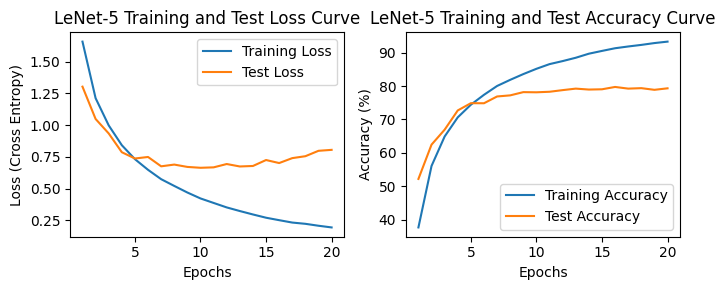


最終テスト精度: 79.31%


In [33]:
# 学習曲線 (損失) のプロット
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs_alexnet + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs_alexnet + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross Entropy)')
plt.title('LeNet-5 Training and Test Loss Curve')
plt.legend()

# 学習曲線 (精度) のプロット
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs_alexnet + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs_alexnet + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('LeNet-5 Training and Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\n最終テスト精度: {test_accuracies[-1]:.2f}%")

# テストデータセットでの最終的な詳細な評価
model_alexnet_cifar.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader_cifar:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_alexnet_cifar(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

## 5. 考察

*   **AlexNetの革新性:**
    *   **深いネットワーク:** LeNet-5よりも多くの畳み込み層と全結合層を持ち、表現能力が向上しました。
    *   **ReLU活性化関数:** 学習の高速化に大きく貢献しました。
    *   **Dropout:** 全結合層での過学習を効果的に抑制しました。
    *   **Data Augmentation:** (今回の実装では直接扱っていませんが) 訓練データを水増しすることで、汎化性能を向上させました。
    *   **LRN:** 当時は性能向上に寄与するとされましたが、現代ではBatch Normalizationが主流です。
    *   **複数GPUでの学習:** 大規模なモデルを効率的に学習するための先駆けとなりました。
    *   **Overlapping Pooling:** 過学習を抑制し、性能をわずかに向上させたと報告されています。

*   **PyTorchによる実装の利点:**
    *   `nn.Conv2d`, `nn.ReLU`, `nn.MaxPool2d`, `nn.Linear`, `nn.Dropout`, `nn.LocalResponseNorm` といった高レベルなモジュールを使うことで、複雑なAlexNetのアーキテクチャも比較的容易に定義できました。
    *   データセットの準備、バッチ化、学習ループ、勾配計算、パラメータ更新といった定型的な処理は、PyTorchの機能によって大幅に簡略化されました。
    *   GPUを利用することで、CIFAR-10のような比較的小さなデータセットでも、それなりのエポック数の学習を現実的な時間で行うことができます。

*   **今回のCIFAR-10での簡易実装について:**
    *   アーキテクチャはCIFAR-10の画像サイズに合わせて調整し、層のチャネル数なども元のAlexNetより小さくしています。そのため、ImageNetでのAlexNetの性能を直接比較することはできません。
    *   適切なハイパーパラメータチューニング（学習率、Optimizer、エポック数、Dropout率など）や、より洗練されたData Augmentationを行うことで、CIFAR-10での精度はさらに向上する可能性があります。
    *   このノートブックの目的は、AlexNetで導入された主要なアイデアを理解し、PyTorchでCNNを構築・学習する一連の流れを体験することです。

AlexNetは、深層学習が画像認識の分野で大きなブレークスルーを達成するきっかけとなった非常に重要なモデルです。その構成要素や設計思想は、後の多くのCNNアーキテクチャに影響を与えています。